In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 991.05it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1030.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 800.89it/s]


In [6]:
from dataset import optDatasetConstrs
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.78it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 1e-2
num_epochs = 20
log_step = 2

In [11]:
import time
from tqdm import tqdm

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # get loss
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

###  Average Method

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import avgConeAlignedCosine

# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

(CVXPY) Dec 05 01:18:31 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  65.5516%, Val Regret:  56.9766%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:09<01:04,  3.57s/it]

Epoch   2, Train Regret:   9.8199%, Val Regret:  12.0655%


Epoch    3, Loss:  -0.9998:  20%|███████████                                            | 4/20 [00:16<00:57,  3.59s/it]

Epoch   4, Train Regret:   8.7768%, Val Regret:   9.3365%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:24<00:49,  3.57s/it]

Epoch   6, Train Regret:   8.5239%, Val Regret:  10.2929%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:31<00:42,  3.51s/it]

Epoch   8, Train Regret:   8.4479%, Val Regret:  10.0816%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [00:38<00:35,  3.56s/it]

Epoch  10, Train Regret:   8.0561%, Val Regret:   9.0705%


Epoch   11, Loss:  -0.9999:  60%|████████████████████████████████▍                     | 12/20 [00:46<00:28,  3.60s/it]

Epoch  12, Train Regret:   8.1205%, Val Regret:   9.0693%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████▊                | 14/20 [00:53<00:21,  3.60s/it]

Epoch  14, Train Regret:   8.5160%, Val Regret:   9.8873%


Epoch   15, Loss:  -0.9999:  80%|███████████████████████████████████████████▏          | 16/20 [01:01<00:14,  3.55s/it]

Epoch  16, Train Regret:   8.5866%, Val Regret:   8.8559%


Epoch   17, Loss:  -0.9999:  90%|████████████████████████████████████████████████▌     | 18/20 [01:08<00:06,  3.50s/it]

Epoch  18, Train Regret:   8.4487%, Val Regret:   9.8930%


Epoch   19, Loss:  -0.9999: 100%|██████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.69s/it]


Epoch  19, Loss:  -0.9999, Train Regret:   8.5922%, Val Regret:   8.7519%

Evaluation:
Test Regret: 9.6482%
Training Elapsed Time: 36.51 Sec


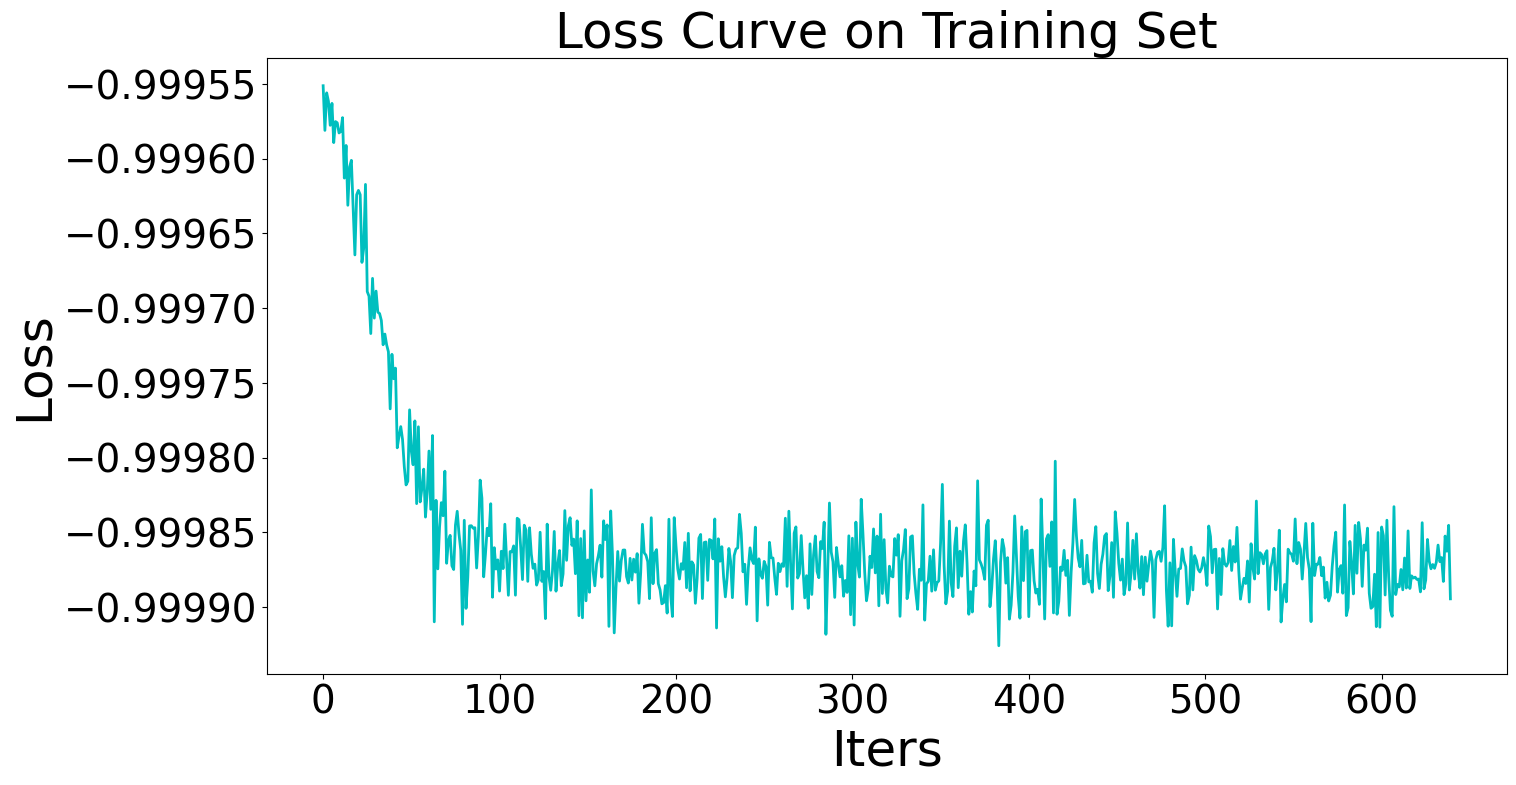

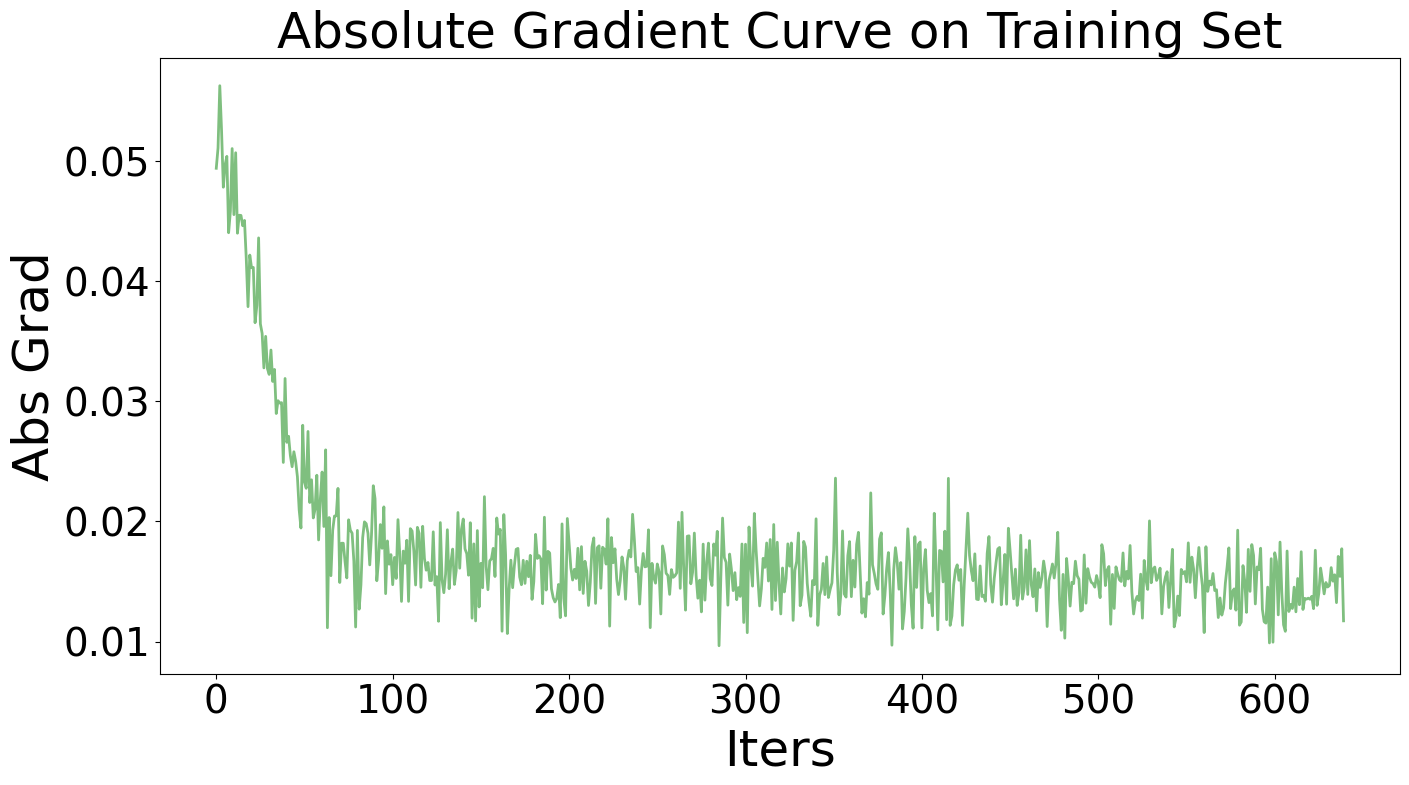

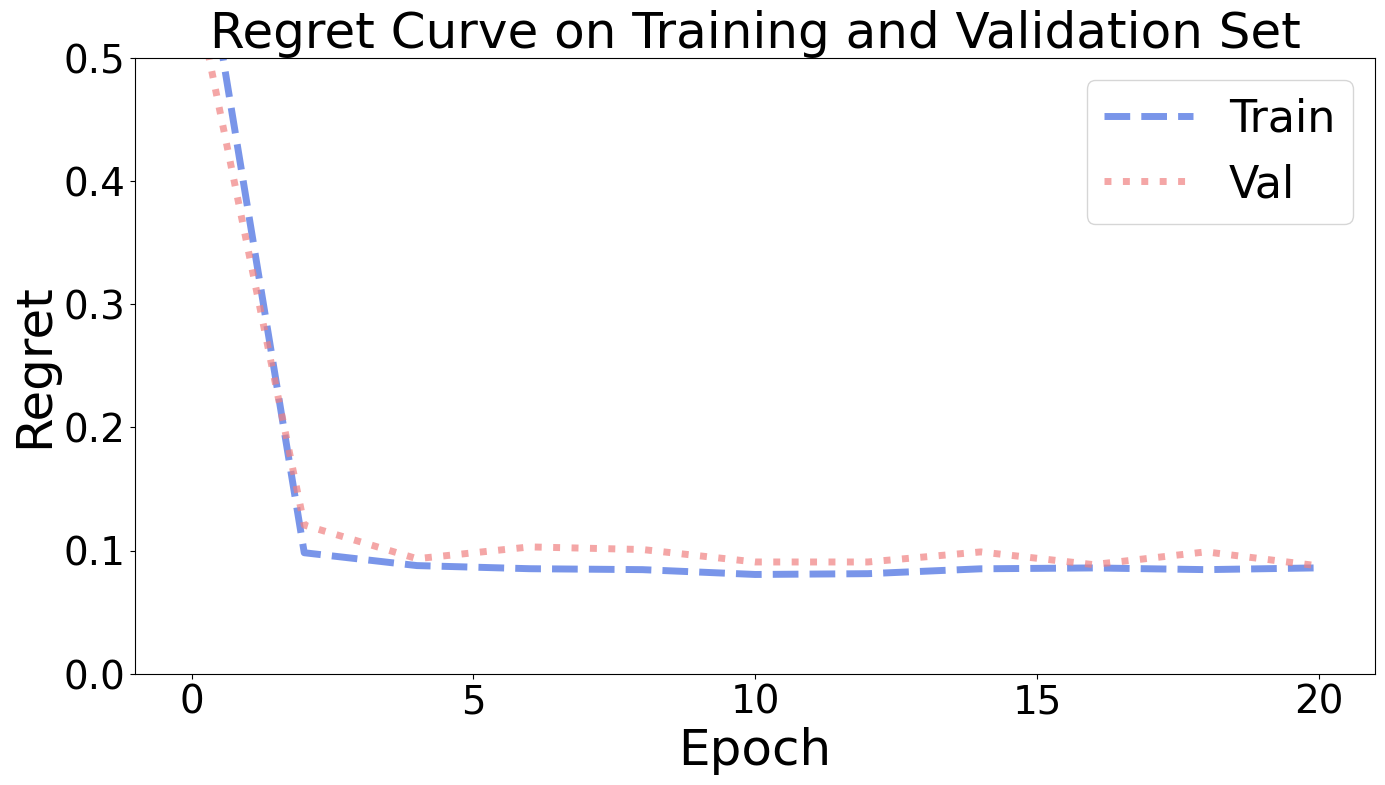

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  53.2812%, Val Regret:  52.3336%


Epoch    1, Loss:  -0.9998:  10%|█████▌                                                 | 2/20 [00:09<01:03,  3.53s/it]

Epoch   2, Train Regret:  12.1130%, Val Regret:  14.2495%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [00:16<00:56,  3.56s/it]

Epoch   4, Train Regret:   9.7031%, Val Regret:  10.5425%


Epoch    5, Loss:  -0.9998:  30%|████████████████▌                                      | 6/20 [00:24<00:50,  3.59s/it]

Epoch   6, Train Regret:   8.3512%, Val Regret:   9.7863%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:31<00:43,  3.65s/it]

Epoch   8, Train Regret:   8.6888%, Val Regret:  10.2021%


Epoch    9, Loss:  -0.9998:  50%|███████████████████████████                           | 10/20 [00:39<00:37,  3.70s/it]

Epoch  10, Train Regret:   8.3284%, Val Regret:   9.7024%


Epoch   11, Loss:  -0.9998:  60%|████████████████████████████████▍                     | 12/20 [00:47<00:29,  3.69s/it]

Epoch  12, Train Regret:   8.2786%, Val Regret:   8.7035%


Epoch   13, Loss:  -0.9997:  70%|█████████████████████████████████████▊                | 14/20 [00:54<00:21,  3.64s/it]

Epoch  14, Train Regret:   8.7137%, Val Regret:   8.5863%


Epoch   15, Loss:  -0.9997:  80%|███████████████████████████████████████████▏          | 16/20 [01:02<00:14,  3.61s/it]

Epoch  16, Train Regret:   8.3096%, Val Regret:   7.9655%


Epoch   17, Loss:  -0.9999:  90%|████████████████████████████████████████████████▌     | 18/20 [01:09<00:07,  3.59s/it]

Epoch  18, Train Regret:   8.5648%, Val Regret:   9.0005%


Epoch   19, Loss:  -0.9997: 100%|██████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.77s/it]


Epoch  19, Loss:  -0.9997, Train Regret:   8.6283%, Val Regret:  10.0153%

Evaluation:
Test Regret: 9.3584%
Training Elapsed Time: 38.04 Sec


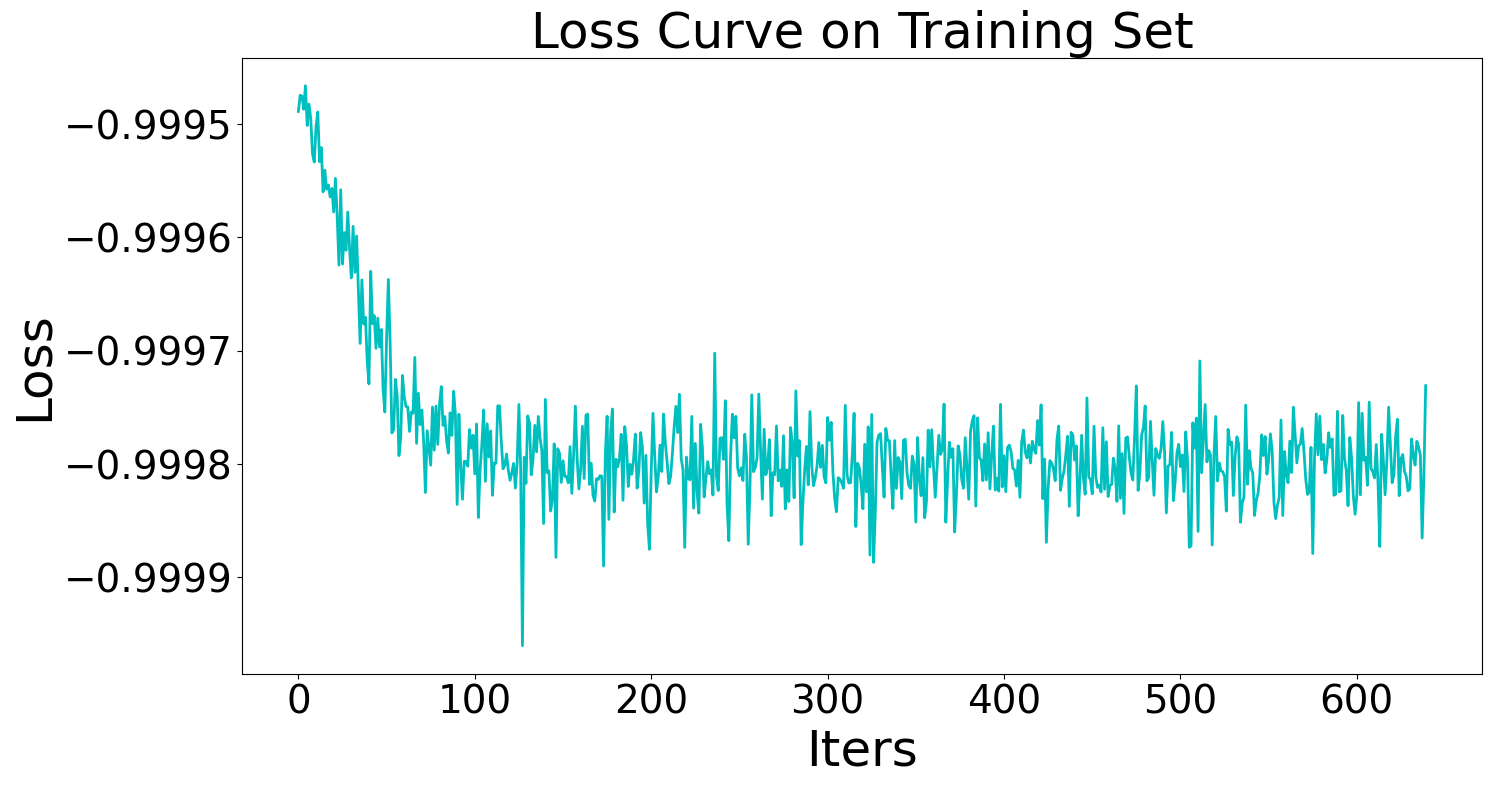

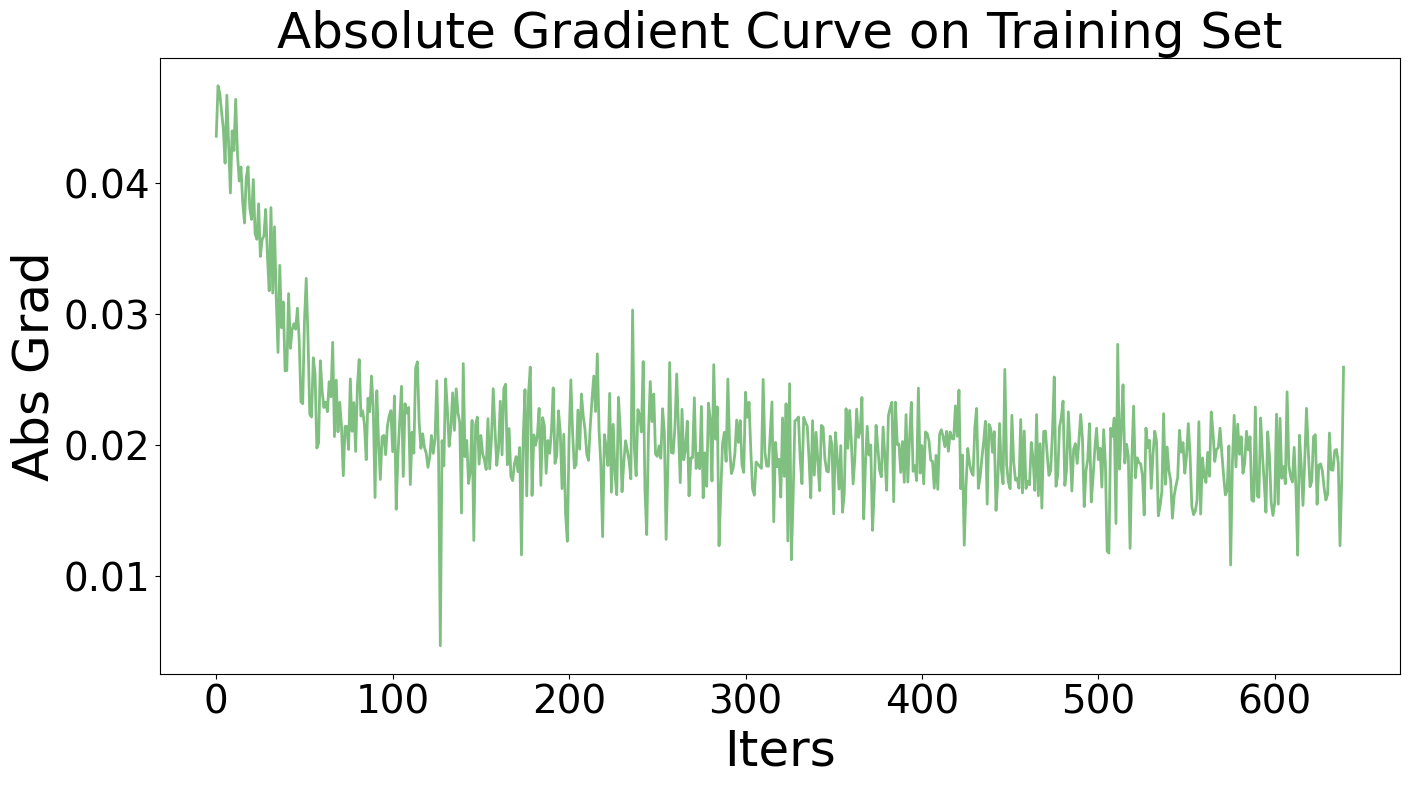

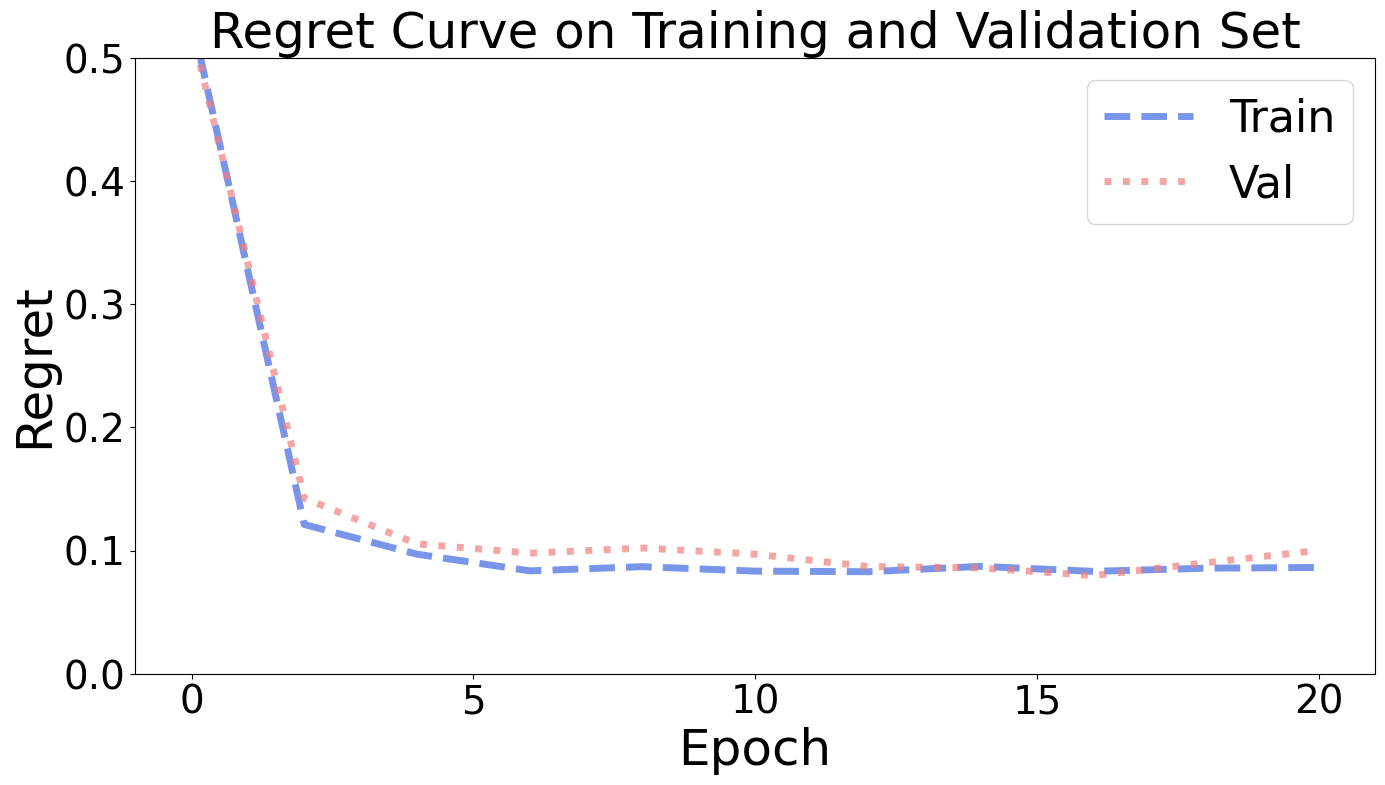

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.1936%, Val Regret:  69.6010%


Epoch    1, Loss:  -0.9980:  10%|█████▌                                                 | 2/20 [00:08<01:00,  3.38s/it]

Epoch   2, Train Regret:  15.9327%, Val Regret:  20.0677%


Epoch    3, Loss:  -0.9985:  20%|███████████                                            | 4/20 [00:15<00:54,  3.41s/it]

Epoch   4, Train Regret:  11.4254%, Val Regret:   9.6979%


Epoch    5, Loss:  -0.9994:  30%|████████████████▌                                      | 6/20 [00:23<00:47,  3.42s/it]

Epoch   6, Train Regret:   9.8944%, Val Regret:   7.8707%


Epoch    7, Loss:  -0.9984:  40%|██████████████████████                                 | 8/20 [00:30<00:41,  3.43s/it]

Epoch   8, Train Regret:   9.4716%, Val Regret:   8.0148%


Epoch    9, Loss:  -0.9995:  50%|███████████████████████████                           | 10/20 [00:37<00:34,  3.45s/it]

Epoch  10, Train Regret:   9.8270%, Val Regret:   8.2476%


Epoch   11, Loss:  -0.9996:  60%|████████████████████████████████▍                     | 12/20 [00:44<00:27,  3.45s/it]

Epoch  12, Train Regret:  10.0404%, Val Regret:   8.7309%


Epoch   13, Loss:  -0.9996:  70%|█████████████████████████████████████▊                | 14/20 [00:51<00:20,  3.44s/it]

Epoch  14, Train Regret:  10.0405%, Val Regret:  10.6909%


Epoch   15, Loss:  -0.9995:  80%|███████████████████████████████████████████▏          | 16/20 [00:58<00:13,  3.42s/it]

Epoch  16, Train Regret:  10.2404%, Val Regret:  11.7135%


Epoch   17, Loss:  -0.9994:  90%|████████████████████████████████████████████████▌     | 18/20 [01:06<00:06,  3.46s/it]

Epoch  18, Train Regret:  11.6727%, Val Regret:  12.3483%


Epoch   19, Loss:  -0.9991: 100%|██████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch  19, Loss:  -0.9991, Train Regret:  12.4643%, Val Regret:  13.6032%

Evaluation:
Test Regret: 14.0953%
Training Elapsed Time: 35.11 Sec


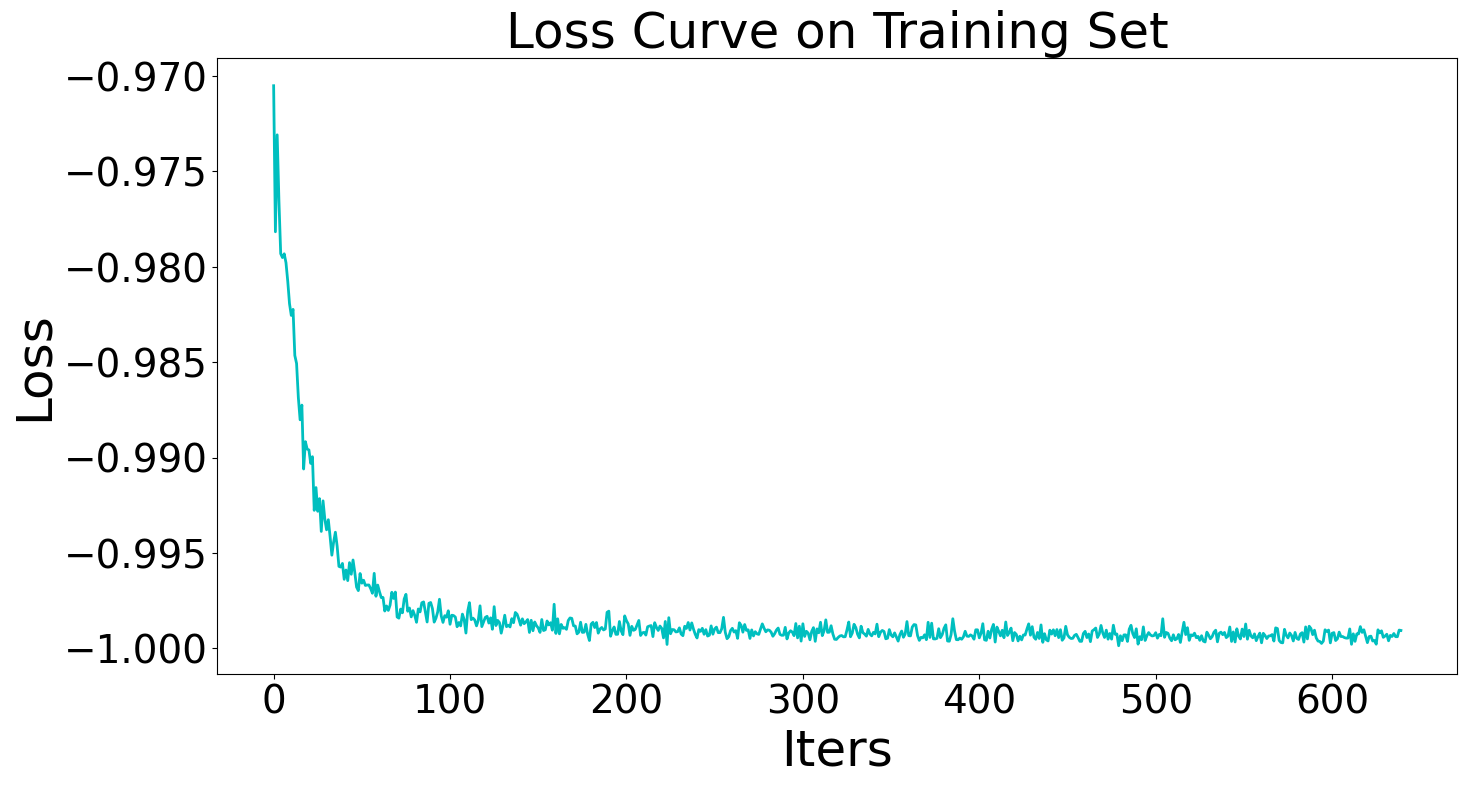

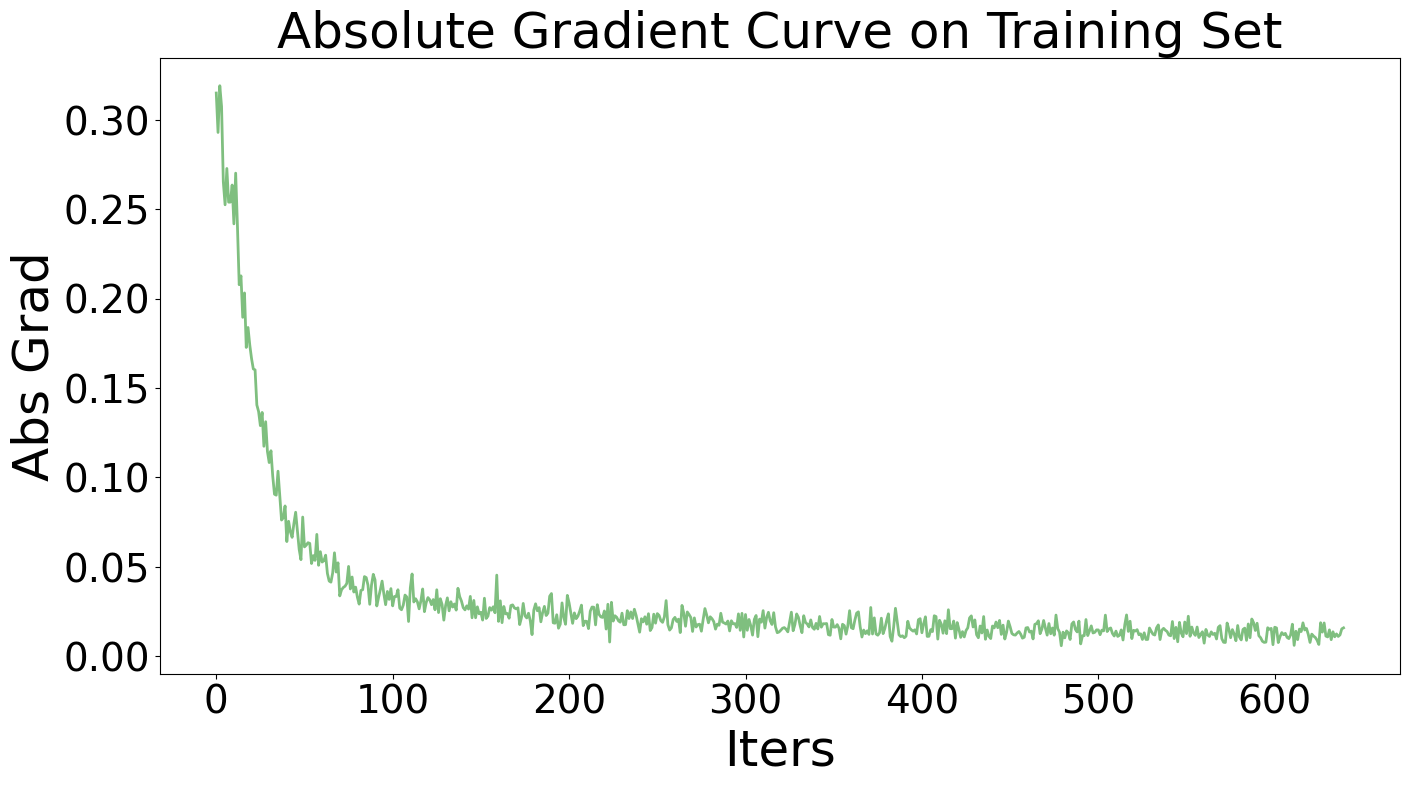

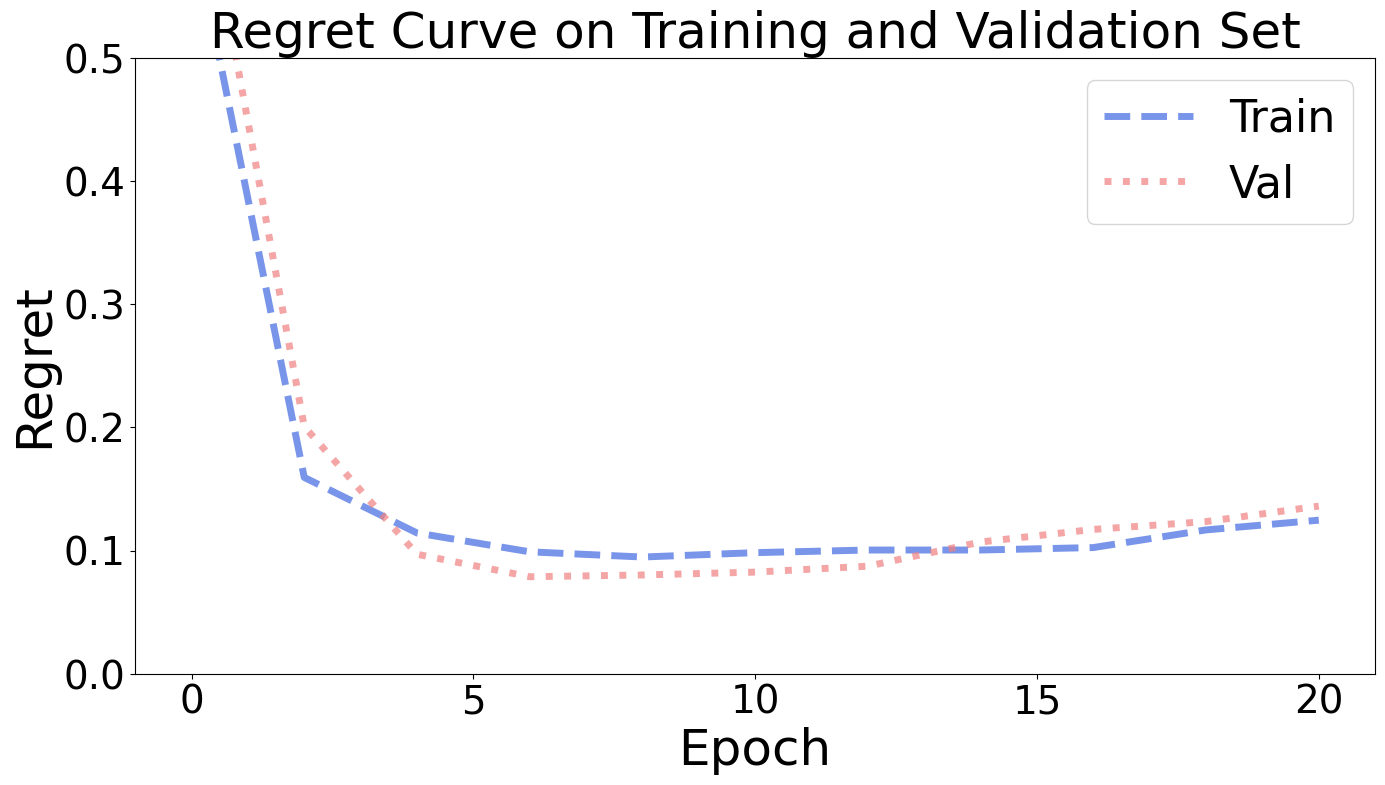

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)